# Global RNN

In this notebook, I train a single ML model across sites and across target variables -- i.e. a global model. Darts syntax makes this task, at first glance, easier than the alternative, to train models for every target variable at every site individually. This is because all you have to do to train a global model is input a list of all the target variables and covariates to the Darts model, but this requires a bit more preprocessing, which is what most of this notebook is dedicated to. I will throw the pre-processing tidbits into utils when I have the chance.

In [4]:
import pandas as pd
from darts import TimeSeries
import numpy as np
import os
from utils import (
    make_stitched_series,
    get_variable_dataframes,
    global_model_preprocess,
    train_local_models, 
    train_global_model,
    make_plot_global,
    make_plot_global_long_horizon,
    make_plot_local
)
import matplotlib.pyplot as plt
import ray 
from darts.models import BlockRNNModel
from darts.utils.likelihood_models import LaplaceLikelihood

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
targets = pd.read_csv("aquatics-targets.csv.gz")
# Maybe put ray.init call somehwhere here

In [5]:
targets.head()

,datetime,site_id,variable,observation
0,2016-03-05,ARIK,chla,NaN
1,2016-03-05,ARIK,oxygen,NaN
2,2016-03-06,ARIK,chla,NaN
3,2016-03-06,ARIK,oxygen,NaN
4,2016-03-07,ARIK,chla,NaN


In the next 3 cells, I do a bit of preprocessing. In the first cell, I create DataFrames of the target variables for each site, such that all the target variable time series will share a common time index. Then, in the second cell, I perform bespoke filtering, where I fit 2 Gaussian Process Filters and stitch them together. This is to account for there being big and small gaps in the data, and one GP filter didn't seem to account well for both of these gaps. I do this latter task using Ray to parallelize the job.

In [6]:
site_dicts = [get_variable_dataframes(site, targets) 
                      for site in targets["site_id"].unique()]

/home/rstudio/neon4cast-darts/utils.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  variable_df_dict[variable] = targets[targets.site_id == site][
/home/rstudio/neon4cast-darts/utils.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  variable_df_dict[variable] = targets[targets.site_id == site][
/home/rstudio/neon4cast-darts/utils.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  variable_df_dict[variable] = targets[targets.site_id == site][
/home/rstudio/neon4cast-darts/utils.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  variable_df_dict[variable] = targets[targets.site_id == site][
/home/rstudio/neon4cast-darts/utils.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  variable_df_dict[variable] = targets[targets.site_id == site][
/home/rstudio/neon4cast-darts/utils.py:20: UserWarning: Boolean Series key will 

In [7]:
stitched_series_list = [make_stitched_series.remote(site_dict) for site_dict in site_dicts]

2023-06-13 22:24:45,055	INFO worker.py:1636 -- Started a local Ray instance.
(make_stitched_series pid=1255404) You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
(make_stitched_series pid=1255404) You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
(make_stitched_series pid=1255404) /home/rstudio/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a b

In [9]:
time_series = ray.get(stitched_series_list)

Now doing the preprocessing which I just throw into utils. This creates lists of the inputs, their corresponding validation sets and the covariates.

In [164]:
inputs, val_set, cov_set = global_model_preprocess(targets, named_ts_dict)

ValueError: Timestamp must be between 2017-08-26 00:00:00 and 2022-09-20 00:00:00
ValueError: Timestamp must be between 2017-08-26 00:00:00 and 2022-09-20 00:00:00
ValueError: Timestamp must be between 2018-08-17 00:00:00 and 2022-09-30 00:00:00
ValueError: Timestamp must be between 2018-08-17 00:00:00 and 2022-09-30 00:00:00
ValueError: Timestamp must be between 2018-08-17 00:00:00 and 2022-09-30 00:00:00


Now, I train the model. This takes a long time, so skip to loading cell to save time.

In [167]:
global_rnn_ = train_global_model.remote(inputs, cov_set)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=1` reached.


BlockRNNModel(model=LSTM, hidden_dim=256, n_rnn_layers=3, hidden_fc_sizes=None, dropout=0.0, batch_size=8, input_chunk_length=15, output_chunk_length=34, likelihood=<darts.utils.likelihood_models.LaplaceLikelihood object at 0x7fc0304c3fa0>, optimizer_kwargs={'lr': 0.0001}, random_state=0)

In [ ]:
global_rnn = ray.get(global_rnn_)

Saving the model as it took a very long time to train.

In [153]:
global_rnn.save("global_block_rnn.pt")

Loading,

In [46]:
rnn_loaded = BlockRNNModel.load("global_block_rnn.pt")

Now, plotting some predictions.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

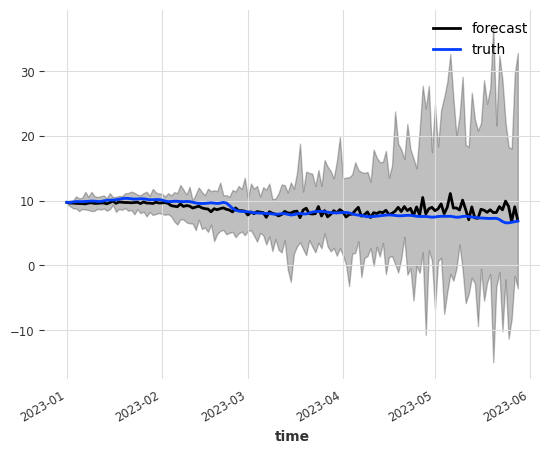

In [177]:
make_plot_long_horizon(rnn_loaded, inputs, 2, cov_set, val_set)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

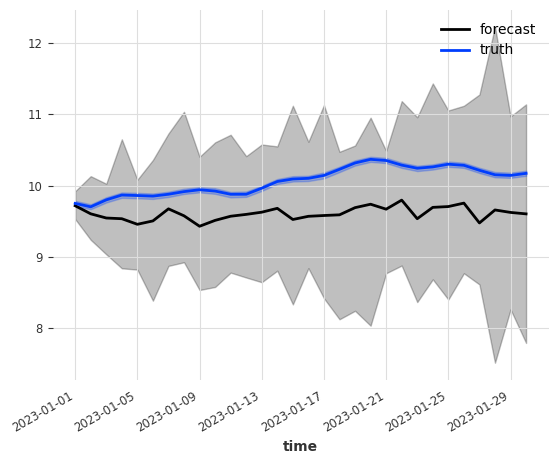

In [178]:
make_plot(rnn_loaded, inputs, 2, cov_set, val_set)

## Now training individual models on each site

Initially, just training one model on one site.

In [180]:
site_models_dict = {site : {} for site in targets["site_id"].unique()}
train_local_model("ARIK", named_ts_dict, site_models_dict)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=250` reached.


This code cell will train on all the sites and their corresponding target variables. Note, this

In [ ]:
import time
start = time.time()
individual_models_list = [train_local_model(site, named_ts_dict, site_models_dict) 
                              for site in targets["site_id"].unique()]
end = time.time()
print(end-start)

for site in targets["site_id"].unique():
    for variable in ["oxygen", "temperature", "chla"]:
        try:
            model = site_models_dict[site][variable][0]
            model.save(f"models/local_{site}_{variable}.pt")
        except:
            continue

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

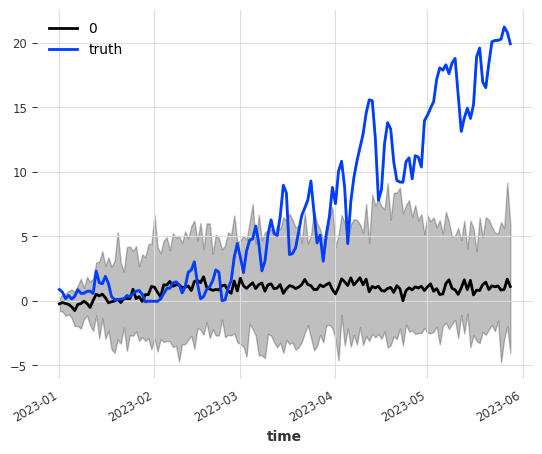

In [190]:
make_plot_local("ARIK", "temperature", site_models_dict)

In [135]:
individual_models_list = [train_local_model(site, named_ts_dict, site_models_dict) 
                              for site in targets["site_id"].unique()]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(train_models pid=1599074) HPU available: False, using: 0 HPUs
(train_models pid=1599074) HPU available: False, using: 0 HPUs
(train_models pid=1599074) HPU available: False, using: 0 HPUs
(train_models pid=1599074) HPU available: False, using: 0 HPUs
(train_models pid=1599332) GPU available: True (cuda), used: True
(train_models pid=1599332) TPU available: False, using: 0 TPU cores
(train_models pid=1599332) IPU available: False, using: 0 IPUs
(train_models pid=1599332) HPU available: False, using: 0 HPUs
(raylet) [2023-06-18 16:58:10,980 E 1255234 1255234] (raylet) node_manager.cc:3069: 11 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 6d5a2fd4de2f1df2432abc1197355b9b0df74f1cfc4552e1b9ace7ce, IP: 172.18.0.16) over the last time